# Доверительные интервалы для оценки среднего

In [1]:
from sklearn import cross_validation, datasets, linear_model, metrics

import numpy as np

C:\Users\KONYAYEV.MAKSIM\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Генерация данных

In [3]:
blobs = datasets.make_blobs(300, centers = 2, cluster_std = 6, random_state=1)

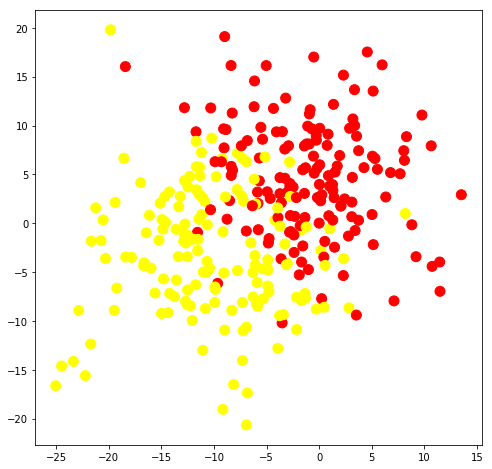

In [4]:
pylab.figure(figsize(8, 8))
pylab.scatter(map(lambda x: x[0], blobs[0]), map(lambda x: x[1], blobs[0]), c = blobs[1], cmap = 'autumn',
             s=100)

## Сравнение линейных моделей

### Точечная оценка

In [5]:
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(blobs[0], blobs[1], 
                                                                                    test_size = 15,
                                                                                    random_state = 1)

In [6]:
ridge_model = linear_model.RidgeClassifier()
ridge_model.fit(train_data, train_labels)
metrics.roc_auc_score(test_labels, ridge_model.predict(test_data))

0.88888888888888884

In [7]:
sgd_model = linear_model.SGDClassifier(random_state = 0)
sgd_model.fit(train_data, train_labels)
metrics.roc_auc_score(test_labels, sgd_model.predict(test_data))

C:\Users\KONYAYEV.MAKSIM\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.88888888888888884

### Оценка среднего

In [8]:
sgd_auc_scores = cross_validation.cross_val_score(linear_model.SGDClassifier(), 
                                 blobs[0], blobs[1], scoring = 'roc_auc',  
                                 cv = 20)

In [9]:
ridge_auc_scores = cross_validation.cross_val_score(linear_model.RidgeClassifier(), 
                                 blobs[0], blobs[1], scoring = 'roc_auc',  
                                 cv = 20)

### Точечная оценка среднего

In [10]:
print "sgd model auc: mean %.3f, std %.3f" % (sgd_auc_scores.mean(), sgd_auc_scores.std(ddof=1))
print "ridge model auc: mean %.3f, std %.3f" % (ridge_auc_scores.mean(), ridge_auc_scores.std(ddof=1))

sgd model auc: mean 0.936, std 0.055
ridge model auc: mean 0.948, std 0.054


### Интервальная оценка среднего 

In [11]:
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic

In [12]:
sgd_mean = sgd_auc_scores.mean()
ridge_mean = ridge_auc_scores.mean()

#### z-интервал

Допустим, нам откуда-то известно, что дисперсия auc_scores $\sigma^2=0.25$. Построим доверительные интервалы для средних вида $$\bar{X}_n \pm z_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}$$

In [13]:
print "sgd model mean auc 95%% confidence interval", _zconfint_generic(sgd_mean, 
                                                                  sqrt(0.25/len(sgd_auc_scores)), 
                                                                  0.05, 'two-sided')

print "ridge model mean auc 95%% confidence interval", _zconfint_generic(ridge_mean, 
                                                                    sqrt(0.25/len(sgd_auc_scores)), 
                                                                    0.05, 'two-sided')

sgd model mean auc 95%% confidence interval (0.71666336995789526, 1.1549246402461861)
ridge model mean auc 95%% confidence interval (0.72886043628442598, 1.1671217065727166)


#### t-интервал

Вместо гипотетической теоретической дисперсии $\sigma^2$, которую мы на самом деле в данном случае не знаем, используем выборочные дисперсии, и построим доверительные интервалы вида $$\bar{X}_n \pm t_{1-\frac{\alpha}{2}} \frac{S}{\sqrt{n}}$$

In [17]:
type(sgd_auc_scores)
sgd_auc_scores

array([ 0.96875   ,  0.859375  ,  0.875     ,  0.859375  ,  1.        ,
        0.90625   ,  0.96875   ,  1.        ,  0.90625   ,  0.984375  ,
        0.97959184,  0.95918367,  0.87755102,  1.        ,  0.95918367,
        1.        ,  0.83673469,  0.95918367,  0.93877551,  0.87755102])

In [15]:
sgd_mean_std = sgd_auc_scores.std(ddof=1)/sqrt(len(sgd_auc_scores))
ridge_mean_std = ridge_auc_scores.std(ddof=1)/sqrt(len(ridge_auc_scores))

In [16]:
print "sgd model mean auc 95%% confidence interval", _tconfint_generic(sgd_mean, sgd_mean_std,
                                                                       len(sgd_auc_scores) - 1,
                                                                       0.05, 'two-sided')

print "ridge model mean auc 95%% confidence interval", _tconfint_generic(ridge_mean, ridge_mean_std,
                                                                         len(sgd_auc_scores) - 1,
                                                                         0.05, 'two-sided')

sgd model mean auc 95%% confidence interval (0.90986715182382616, 0.96172085838025523)
ridge model mean auc 95%% confidence interval (0.92287832593023689, 0.97310381692690573)
